# AdaFlix Milestone 2

# Imports, loading and downloads

In [27]:
#! pip install spacy
#!pip install -U textblob
#!pip install --user -U nltk
#!python -m spacy download en_core_web_sm

In [28]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import nltk
import spacy
import string
from scipy import stats
from textblob import TextBlob
from collections import Counter
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from sklearn import preprocessing
from nltk.corpus import subjectivity
from nltk.tokenize import word_tokenize
from spacy.lang.en.examples import sentences
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scripts.helper import *
from scripts.plot import *
from loads import *
import os

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
stop_words.add(string.punctuation)

PATH_FOLDER = "MovieSummaries/"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\41794\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\41794\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Loading character metadata DataFrame
character_df = load_character_metadata()
# Loading movie metadata DataFrame
movie_df = load_movie_metadata()
# Loading plot summaries DataFrame
plot_summaries_df = load_plot_summaries()
# Loading TVTropes DataFrame
tvtropes_df = load_tvtropes()
# Loading name clusters DataFrame
name_clusters_df = load_name_clusters()
# Load external df, for more details run the scripts/html_parser_oussama.ipynb
external_df = pd.read_csv("external_dataset/boxofficemojo_dataframe.csv")
# Loading inflation DataFrame
inflation = pd.read_excel("external_dataset/inflation.xlsx", header=11)

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Preprocessing

## Movie Cleaning

We are first extracting variables that have the form (ID : variable) tuples to be able to use these features.

In [30]:
# Extracting and transforming the 'Movie languages (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of language names
movie_df['Movie_Languages'] = movie_df['Movie languages (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie countries (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of country names
movie_df['Movie_Countries'] = movie_df['Movie countries (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))
# Extracting and transforming the 'Movie genres (Freebase ID:name tuples)' column
# Applying a lambda function to convert the JSON-like string to a list of genre names
movie_df['Movie_Genres'] = movie_df['Movie genres (Freebase ID:name tuples)'].apply(lambda x: list(json.loads(x).values()))

A lot of columns in the dataframe contain IDs that we don't need, we are thus dropping them.

In [31]:
# List of columns to be dropped from the DataFrame
movie_columns_to_drop = ['Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)','Movie genres (Freebase ID:name tuples)','Freebase movie ID']
# Dropping specified columns from the DataFrame
movie_df.drop(movie_columns_to_drop, axis=1, inplace=True)

Let's first check the number of missing values (Nan), in each column.

In [32]:
# Check the number of Nans in each column
print(movie_df.isna().mean())

Wikipedia_movie_ID          0.000000
Movie_name                  0.000000
Movie_release_date          0.084437
Movie_box_office_revenue    0.897224
Movie_runtime               0.250180
Movie_Languages             0.000000
Movie_Countries             0.000000
Movie_Genres                0.000000
dtype: float64


We can see that 89% of the revenues are missing. Our main interest is to study what feature result in high box office revenues, so we will need to drop the missing revenues.

In [33]:
# Dropping rows from the DataFrame where 'Movie box office revenue' is NaN
movie_df.dropna(subset=['Movie_box_office_revenue'], inplace=True)

The remaining columns containing NaN values will be addressed individually later in the code. Dropping all NaN values at this point would result in the loss of information with respect to other columns that do not contain NaN values.

One of our feature of interest is the release date of the movies. We are thus, processing the column, for it to be usable in our analysis. We extract Year and Month from the Movie release date (date format YYYY and YYYY-MM-DD can't be dealt together).

In [34]:
# Dropping rows where 'Movie release date' is NaN
movie_df.dropna(subset=["Movie_release_date"], inplace=True)
# Create a Year column in the movie dataframe
movie_df['Year'] = movie_df["Movie_release_date"].apply(lambda x: str(x)[:4]).astype(int)
# Create a Month column in the movie dataframe
movie_df['Month'] = pd.to_datetime(movie_df['Movie_release_date'],errors='coerce').dt.month

## Inflation and box office revenues distribution

To be able to compare the relative box office revenues across different years, we need to take inflation into account.

In [35]:
# Calculate cumulative inflation to 2022 using the last available annual inflation rate
inflation["Cumulative Inflation to 2022"] = inflation.iloc[-1].Annual / inflation["Annual"]
# Merge the movie DataFrame with the inflation DataFrame on the 'Year' column
movie_with_inflation = pd.merge(movie_df, inflation, on='Year')
# Calculate revenue with inflation by multiplying 'Movie box office revenue' with the 'Cumulative Inflation to 2022'
movie_with_inflation['Revenue_with_inflation'] = movie_with_inflation['Movie_box_office_revenue'] * movie_with_inflation['Cumulative Inflation to 2022']
movie_with_inflation.drop(['Cumulative Inflation to 2022', 'Annual'], axis=1, inplace=True)

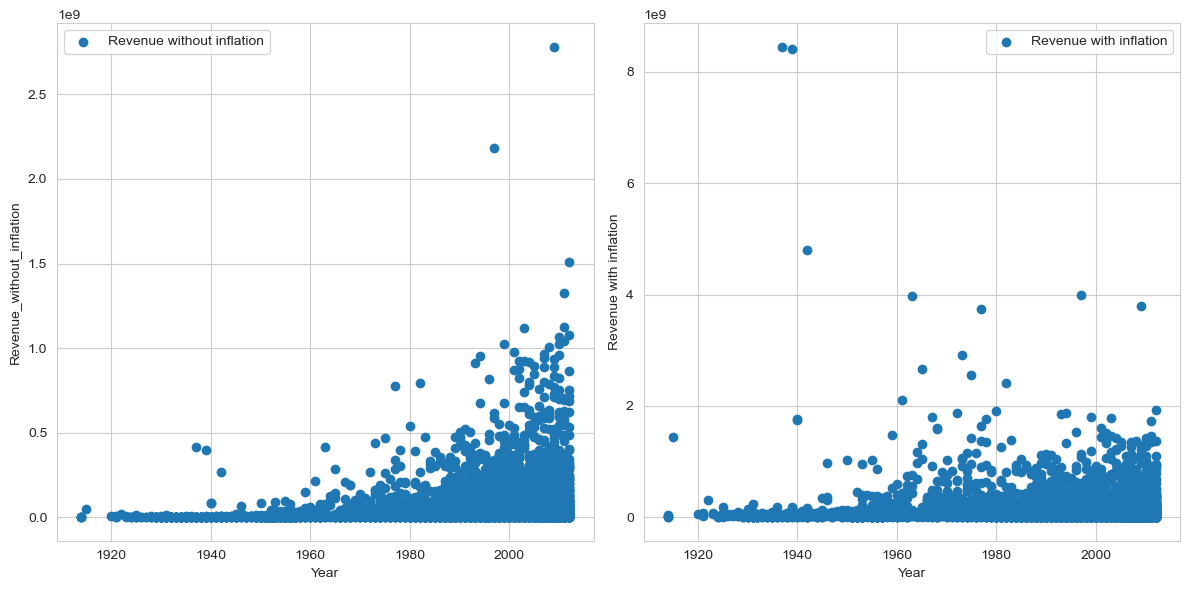

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot for Revenue without inflation
ax1.scatter(movie_with_inflation['Year'], movie_with_inflation['Movie_box_office_revenue'], label='Revenue without inflation')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue_without_inflation')
ax1.legend()

# Plot for Revenue with inflation
ax2.scatter(movie_with_inflation['Year'], movie_with_inflation['Revenue_with_inflation'], label='Revenue with inflation')
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue with inflation')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

The original distribution of the inflated movie box office revenue exhibits a heavy-tailed pattern, with a few movies achieving extremely high revenues. By applying a logarithmic transformation on the x-axis, we "approximate" a normal distribution, making the data more amenable to statistical analyses that assume normality.

Text(0, 0.5, 'Number of movies')

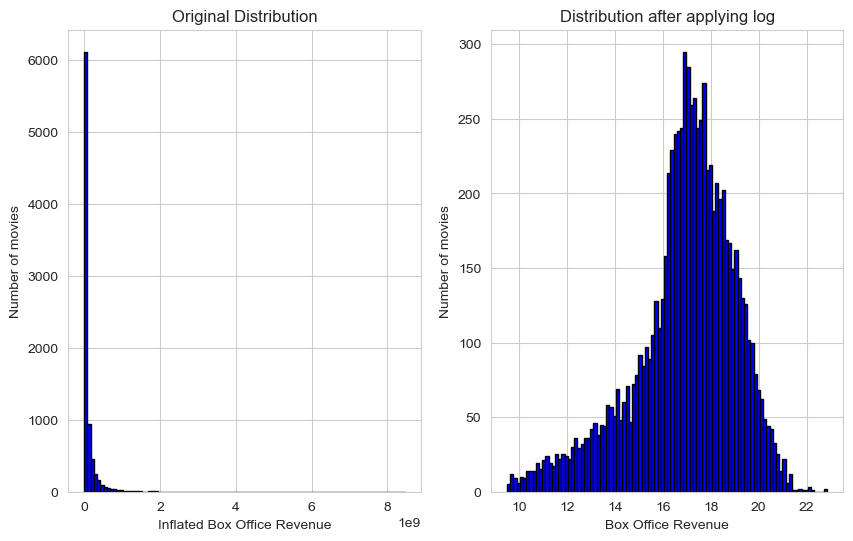

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plotting the original distribution and the distribution after applying log function on the revenue feature
movie_with_inflation['Revenue_with_inflation'].hist(ax=axs[0], bins=100, color='blue', edgecolor='black')
movie_with_inflation['log_revenues'] = np.log(movie_with_inflation['Revenue_with_inflation'])
movie_with_inflation['log_revenues'].hist(ax=axs[1], bins=100, color='blue', edgecolor='black')
axs[0].set_title('Original Distribution')
axs[0].set_xlabel('Inflated Box Office Revenue')
axs[0].set_ylabel('Number of movies')
axs[1].set_title('Distribution after applying log')
axs[1].set_xlabel('Box Office Revenue')
axs[1].set_ylabel('Number of movies')

## Character Cleaning

Again, a lot of columns in the dataframe contain IDs that we don't need, as well as actors' heights, we are thus, dropping them.

In [39]:
# Dropping unnecessary character-related columns from the DataFrame
character_columns_to_drop = ['Freebase movie ID', 'Actor ethnicity (Freebase ID)','Freebase character ID','Freebase actor ID','Actor height (in meters)']
character_df.drop(character_columns_to_drop, axis=1, inplace=True)

As before, we will not drop all the NaNs right now, instead, missing values will be dealt with, once the dataset is split into smaller dataframes.

## Splitting

We are now splitting the dataframes into many small different dataframes for each feature. Each small dataframe has one feature, inflated box office revenue, and 'log_revenues'. These small dataframes are created for the analysis to be easier.

In [40]:
# Extracting 'Movie runtime' and revenue columns into a new dataframe
movie_runtime_df = movie_with_inflation[['Wikipedia_movie_ID','Movie_runtime','Revenue_with_inflation', 'log_revenues']].copy()
# Extracting 'Movie Languages' and revenue columns into a new dataframe
movie_languages_df = movie_with_inflation[['Wikipedia_movie_ID','Movie_Languages','Revenue_with_inflation', 'log_revenues']].copy()
# Extracting 'Movie Countries' and revenue columns into a new dataframe
movie_countries_df = movie_with_inflation[['Wikipedia_movie_ID','Movie_Countries', 'Revenue_with_inflation','log_revenues']].copy()
# Extracting 'Movie Genres' and revenue columns into a new dataframe
movie_genres_df = movie_with_inflation[['Wikipedia_movie_ID','Movie_Genres', 'Revenue_with_inflation','log_revenues']].copy()
# Extracting 'Month' and revenue columns into a new dataframe
months_df = movie_with_inflation[['Wikipedia_movie_ID','Month','Revenue_with_inflation', 'log_revenues']].copy()
# Extracting 'Year' and revenue columns into a new dataframe
years_df = movie_with_inflation[['Wikipedia_movie_ID','Year', 'Revenue_with_inflation','log_revenues']].copy()

Drop movies in each small dataframe, only for the missing values (Nan) of the concerned feature.

In [41]:
# Drop NaNs in each small dataframes
movie_runtime_df.dropna(subset=['Movie_runtime'], inplace=True)
movie_languages_df.dropna(subset=['Movie_Languages'], inplace=True)
movie_countries_df.dropna(subset=['Movie_Countries'], inplace=True)
movie_genres_df.dropna(subset=['Movie_Genres'], inplace=True)
years_df.dropna(subset=['Year'], inplace=True) #no nan but safer
months_df.dropna(subset=['Month'], inplace=True)

We then need to merge character and movie dataframes, to be able to extract information on actors and their impact on box office revenues

In [42]:
# Merging character_df and movie_with_inflation DataFrames on 'Wikipedia movie ID'
# Dropping the 'Movie release date' column from character_df to avoid duplicate columns after the merge
character_movie_merged_df = pd.merge(character_df.drop(['Movie_release_date'],axis=1), movie_with_inflation, on=['Wikipedia_movie_ID'])


One of our feature will be the percentage of actress in movies, so we need to get this information.

In [43]:
# Create a new DataFrame containing relevant columns from the original DataFrame
actor_gender_movie_df = character_movie_merged_df[['Wikipedia_movie_ID','Movie_name','log_revenues','Actor_name','Actor_gender','Revenue_with_inflation']].copy()
# Drop rows with missing values
actor_gender_movie_df.dropna(inplace=True)
# Compute percentage of women in each movies
actor_gender_movie_df['Percentage_Women'] = (actor_gender_movie_df.groupby('Movie_name')['Actor_gender']
                                              .transform(lambda x: (x == 'F').mean() * 100)
                                              .fillna(0)  # Fill NaN with 0
                                              .astype(int)  # Ensure the column is of int type
                                             )

In [44]:
# Creating a DataFrame with actor gender, movie name, and log_revenues from the merged DataFrame
gender_df = actor_gender_movie_df[['Wikipedia_movie_ID','Percentage_Women','Movie_name','log_revenues','Revenue_with_inflation']].copy()
# Removing duplicate rows from actor_gender_df based on all columns
gender_df.drop_duplicates(inplace = True)
# Creating a new DataFrame with percentage women and log_revenues, dropping rows with missing percentage women
gender_df.dropna(subset=['Percentage_Women'], inplace=True)

In [45]:
# Creating a DataFrame with actor name, actor age at movie release, and log_revenues from the merged DataFrame
actor_df = character_movie_merged_df[['Wikipedia_movie_ID','Actor_name','Actor age at movie release','log_revenues','Revenue_with_inflation']].copy()
actor_df.dropna()

,Wikipedia_movie_ID,Actor_name,Actor age at movie release,log_revenues,Revenue_with_inflation
0,975900,Wanda De Jesus,42.0,16.957621,2.315268e+07
1,975900,Natasha Henstridge,27.0,16.957621,2.315268e+07
2,975900,Ice Cube,32.0,16.957621,2.315268e+07
3,975900,Jason Statham,33.0,16.957621,2.315268e+07
4,975900,Clea DuVall,23.0,16.957621,2.315268e+07
...,...,...,...,...,...
100848,6456053,Roland Culver,64.0,17.746917,5.097861e+07
100849,6456053,Michael Hordern,53.0,17.746917,5.097861e+07
100850,6456053,Reginald Beckwith,56.0,17.746917,5.097861e+07
100851,32837210,Gong Yoo,32.0,17.503715,3.997302e+07


# Feature selection and data analysis

In this section, we will perform offline feature selection. We will analyze each feature independently and check it is correlated with the box office revenues of the movies. This way, we can decide what feature we want to keep in the final formula for predicting a movie's success.

## Release month

We first check if there is a correlation between the release month of a movie and the box office revenue.

In [51]:
# Compute the correlation between release month and log revenues
stats.spearmanr(months_df['Month'], months_df['log_revenues'])

SignificanceResult(statistic=0.09366287903172422, pvalue=1.0366280870920575e-14)

By running the spearman correlation test, we can see that the pvalue << 0.05 which rejects the null hypothesis that the box office revenues and release month are uncorrelated. Investigating which months result in higher box office revenues is thus a good idea.

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


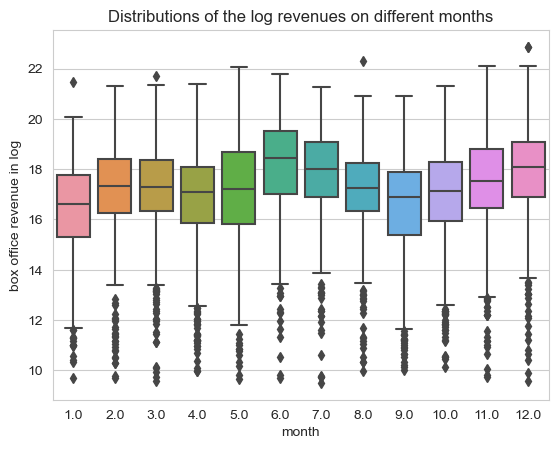

In [52]:
# boxplot of the revenues for each month
sns.boxplot(x='Month', y='log_revenues', data=months_df)
plt.title("Distributions of the log revenues on different months")
plt.ylabel("box office revenue in log")
plt.xlabel("month")
plt.show()

We observe that movies released in June tend to earn the most money at the box office, followed by July and December. This pattern aligns with the months when students typically have vacations, which could partly explain the results.
Let's run a regression analysis to confirm our results.

In [53]:
# Declares the model
mod = smf.ols(formula='log_revenues ~ C(Month)', data=months_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print the summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     39.34
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           3.89e-83
Time:                        01:09:01   Log-Likelihood:                -14339.
No. Observations:                6792   AIC:                         2.870e+04
Df Residuals:                    6780   BIC:                         2.878e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           16.3052      0.088  

The regression analysis confirms that the greatest coefficients are indeed the ones associated to June, July and December. In addition, the p_values associated to each of these months are smaller than 0.05, except for September, meaning that the coefficients are almost all statistically significant and that they probably all impact the box office revenue. We will thus take release months in our final formula for predicting a movie's success.

## Women percentage

We are now interested into the proportion of men and women actors in movies. We will analyze if there is a particular proportion that generally results in higher box office revenue. To this extend, we will analyze the percentage of actress in movies and how they relate to the box office revenues.

In [54]:
stats.spearmanr(gender_df['Percentage_Women'], gender_df['Revenue_with_inflation'])

SignificanceResult(statistic=-0.08966832643024661, pvalue=5.1617017932619725e-16)

Again, by running the spearman correlation test, we can see that the pvalue << 0.05 which rejects the null hypothesis that the box office revenues and percentage of women actresses are uncorrelated. We will thus further investigate this feature.

We will now perform an equal frequency discretization of the percentage of women, to divide percentages into 8 groups where we have an equal number of movies in each group. This way, instead of feeding the final formula with an actual percentage of women, we will feed it with categorical variables.

In [56]:
# Set number of groups
num_groups = 8
# Sort the DataFrame by 'Percentage_Women'
gender_df = gender_df.sort_values(by='Percentage_Women')

# Create bins based on quantiles
gender_df['group'] = pd.qcut(gender_df['Percentage_Women'], q=num_groups, labels=False, duplicates='drop')

# Display grouped summary
grouped_summary = gender_df.groupby('group').agg({'Percentage_Women': ['count', 'mean', 'min', 'max'],
                                                'log_revenues': 'mean'})
display(grouped_summary)

Percentage_Women                     log_revenues
                 count       mean min  max         mean
group                                                  
0                 1177   7.256585   0   14    16.889718
1                  894  18.029083  15   20    17.352263
2                 1034  23.864603  21   26    17.135323
3                 1569  30.563416  27   33    16.991490
4                  491  35.987780  34   37    17.233683
5                 1044  41.104406  38   44    16.949693
6                  958  48.669102  45   50    16.568074
7                  978  64.248466  51  100    16.505155

C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\41794\anaconda3\envs\ada\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


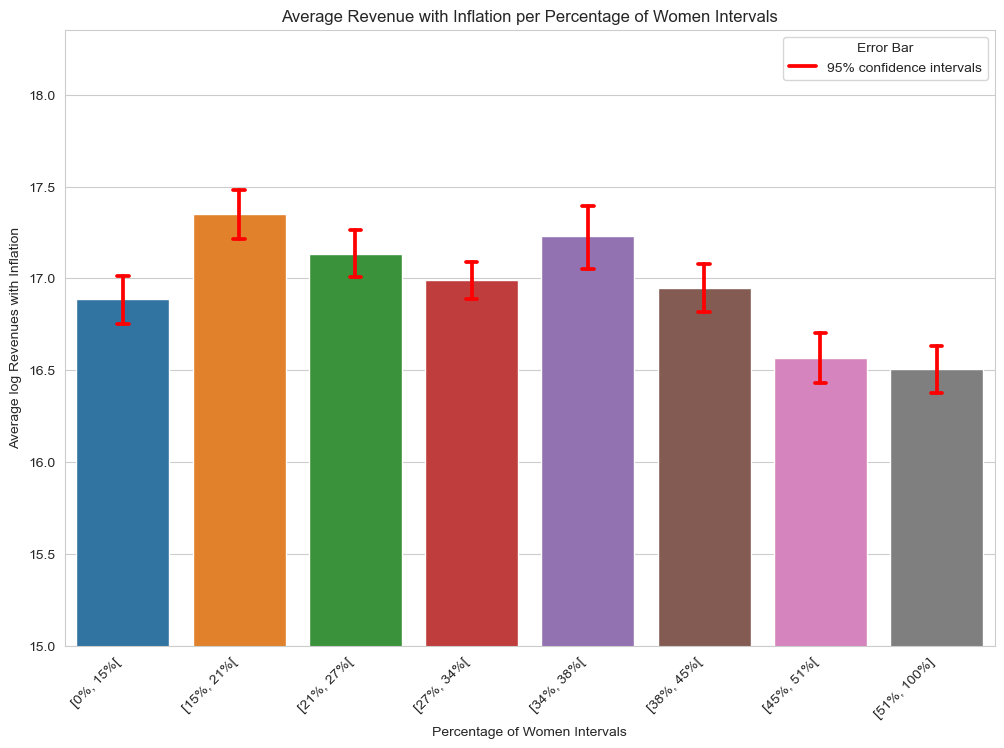

In [57]:
# Boxplot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=gender_df['group'], y=gender_df['log_revenues'], estimator='mean', errorbar=('ci', 95), capsize=0.1, errcolor='red')

# Customize x-axis labels
custom_labels = ["[0%, 15%[", "[15%, 21%[", "[21%, 27%[", "[27%, 34%[", "[34%, 38%[", "[38%, 45%[","[45%, 51%[", "[51%, 100%]"]

ax.set_xticklabels(custom_labels, rotation=45, ha='right')

plt.ylim(15, None)
plt.xlabel('Percentage of Women Intervals')
plt.ylabel('Average log Revenues with Inflation')
plt.title('Average Revenue with Inflation per Percentage of Women Intervals')

# Add legend
plt.legend(title='Error Bar', labels=['95% confidence intervals'])

plt.show()

From the plot, we can see that movies with women percentage between 15% and 21% result in significantly higher box office revenues, followed by movies that have women percentage of 34% to 38%. While movies with 45% to 100% have significantly lower mean box office revenues, and their confidence intervals don't intersect with other intervals.
We will now perform a regression analysis to better see if being in one of these groups have a significant impact on the box office. We will use the log revenues as the dependent variable.

In [58]:
# Declares the model
mod = smf.ols(formula='log_revenues ~ C(group)', data=gender_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print the summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     17.97
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           7.38e-24
Time:                        01:20:39   Log-Likelihood:                -17622.
No. Observations:                8145   AIC:                         3.526e+04
Df Residuals:                    8137   BIC:                         3.532e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.8897      0.061    275.059

R squared = 0.021 confirms the small correlation between percentage of women and box office revenues, so taking the feature into account in the final formula is thus natural. The negative coefficients associated to the last two groups confirms our observation that having more than 45% of actress in a movie generally result in lower box office revenue. In addition, we can see that most of the p_values are smaller than 0.05, except for group 4 and 6.

## Release year

Let's now investigate the link between revenues and release year. We again perform discretization of the feature to use it as a categorical variable in the final formula. We will this time group years into chunks of size 10.

In [59]:
# Calculate the minimum and maximum years in the 'Year' column
min_year = years_df['Year'].min()
max_year = years_df['Year'].max()

# Create intervals of 10 years and assign labels based on the minimum and maximum years
years_df['year_intervals'] = pd.cut(years_df['Year'],
                                    bins=range(min_year, max_year + 11, 10),  # Define bins for 10-year intervals
                                    labels=[f"{start}-{start + 9}" for start in range(min_year, max_year, 10)],  # Create labels for intervals
                                    include_lowest=True)  # Include the lowest value in the interval

In [60]:
# Declares the model
mod = smf.ols(formula=' log_revenues ~ year_intervals', data=years_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print the summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           log_revenues   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     44.74
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           3.53e-79
Time:                        01:32:03   Log-Likelihood:                -17952.
No. Observations:                8326   AIC:                         3.592e+04
Df Residuals:                    8316   BIC:                         3.599e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

We can see that none of these intervals have a p_value greater than 0.05. This suggests that there is no correlation between release year and box office revenues. This can be explained by the fact that we normalized revenues with inflation. However, we think that combining years with other features such as genre could still yield some interesting results, since different genres have been popular during different years. For this reason, we will take years in the final formula, even if it individually doesn't impact the box office.